This notebook is used to process MPOA-1pimaging data during resident intruder assay. The signal will be extracted using the Inscopix data processing software, the behavior information was manually annotated using Boris.

The notebook uses functions saved in inscopix_library.py. 

In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import peakutils
from inscopix_library import *
import math


# Set path information and load meta data

In [2]:
# paths for raw data
# the inscopix data will be saved in the tracefolderpath as trace csv
# the behavior data, in this case manually annotated data, will be 

behaviorfolderpath = r"...\Boris_behavior"
tracefolderpath = r"...\traces"
resultfolderpath = r"...\results"
figurepath = r"...\figures"
summaryfigurepath = r"...\summary_figures"
metainfopath = r"...\metadata"

Meta data is saved in a csv. Contains information of the experiment.

In [3]:
# load meta data
metainfo = pd.read_csv(os.path.join(metainfopath,"metainfo.csv"),index_col = False)

# Specify certain variables that are necessary to process the data

In [4]:
# set the basic variables necessary to process data
onset = 1.033 # an onset from video start to recording start, usually a second

# The types of behaviors recorded in the behavior files
behavior_keys = ['entry','sniff','mount','intro','ejac']
status_keys = ['POINT','STAT','STAT','STAT','POINT']

In [5]:
# plotting variables
before_window = 5
after_window = 15

# framerate of the signal data
signal_framerate = 10 # the inscopix signal data is exported as 10 Hz

# convert to frames
before_frames = before_window * signal_framerate
after_frames = after_window * signal_framerate

# 
plot_key = True

# Load individual data and export event-locket signals

My experiments can be specified by a "data_key". The data_key is used to load the trace data, behavior data, as well as the metainformation using the metainfo dataframe.

In [6]:
data_key = '211018_m490_sexual-interaction_e'

In [7]:
data_key,Date,ID,Trial,Session_type,Ethovision_key = metainfo.loc[metainfo.data_key == data_key,['data_key','Date','ID','Trial','Session_type','Ethovision_key']].values[0]

In [9]:
# load the paths to the signal data and the behavior data
tracedatapath= [os.path.join(tracefolderpath,ID,f) for f in os.listdir(os.path.join(tracefolderpath,ID))
                if data_key in f and not 'props' in f][0]
behaviordatapath = [os.path.join(behaviorfolderpath,f) for f in os.listdir(behaviorfolderpath)
                if data_key in f ][0]

The behavior data was created using BORIS. It has multiple columns. The function create_dict_from_boris will load the ['Time '],['Behavior'],['Status'] columns to create a dictionary which stores the time and type of behavior in a dictionary format

In [10]:
# get meta data from the behavior file
behaviordf_meta = pd.read_csv(behaviordatapath,header = None)
observation_id,observation_date = behaviordf_meta.loc[[0,6+Ethovision_key],1].values
observation_date = datetime.strptime(observation_date, '%Y-%m-%d %H:%M:%S')

behaviordf = pd.read_csv(behaviordatapath,header = 15+Ethovision_key)

# convert behavior data into a dictionary
behavior_dict = create_dict_from_boris(behaviordf)

Signal data will be csv files exported using the Inscopix data processing software. When loaded using pandas, it will be a dataframe object with the following structure (c,r) = (cell, time). 

In [11]:
tracedatapath

'\\\\128.95.12.251\\LabCommon\\Ken\\data\\Pregnancy\\MPOA\\1pimaging\\traces\\m490\\KI_211018_m490_sexual-interaction_e.csv'

In [12]:
# get signal data
tracedf = pd.read_csv(tracedatapath,header = [0,1],index_col = 0)

The following cell will caculate the framerate of the imaging signal, clean up the signal csv.

In [13]:
# subset to accepted columns
subset_tracedf = tracedf.loc[:,tracedf.columns.get_level_values(1).str.contains('accepted')]
cell_names = [f.replace(' ','') for f in list(subset_tracedf.columns.get_level_values(0))]
subset_tracedf.columns = cell_names
time = subset_tracedf.index.values

subset_tracedf.index.names = ['Time(s)']

# extract the framerate of the signal data
signal_framerate = int(1/np.round((time[-1] - time[0])/len(time),1))

To normalize the signal data, I use a package called peakutils, where you can calculate the baseline. This will NOT be used much in the acutal analysis, this is more for checking the entire signal by eye.

In [14]:
# normalize the data using a baseline extraction algorythm
norm_subset_tracedf = subset_tracedf.copy()
for cell_id in cell_names:
    #plt.plot(subset_tracedf.index,subset_tracedf[cell_id])
    norm_subset_tracedf[cell_id] = (subset_tracedf[cell_id].values - peakutils.baseline(subset_tracedf[cell_id]))/peakutils.baseline(subset_tracedf[cell_id]).mean()
    #plt.plot(norm_subset_tracedf.index,norm_subset_tracedf[cell_id])
    

In [15]:
# save the trace files
norm_subset_tracedf.to_csv(os.path.join(resultfolderpath,data_key + "_norm_trace.csv"))
subset_tracedf.to_csv(os.path.join(resultfolderpath,data_key + "_trace.csv"))

## Analyze behavior related events for individual experiments

In [17]:
# paths for raw data
# the inscopix data will be saved in the tracefolderpath as trace csv
# the behavior data, in this case manually annotated data, will be 

behaviorfolderpath = r"...\Boris\csv"
tracefolderpath = r"...\traces"
resultfolderpath = r"...\results"
figurepath = r"...\figures"

In [18]:
# create path for figures
individualfigurepath = os.path.join(figurepath,data_key)
if not os.path.exists(individualfigurepath):
    os.mkdir(individualfigurepath)

In [19]:
# load the trace
subset_tracedf = pd.read_csv(os.path.join(resultfolderpath,data_key + "_trace.csv"),index_col = 0)

# set index and columns
cell_names = subset_tracedf.columns
time = subset_tracedf.index.values
subset_tracedf = subset_tracedf.reset_index(drop = True)

convert_behavior_dict_to_frame: 
for each time point stored in the behavior dictionary, this function will find the frame where there was an image acqusition. As result, this will convert the time information in the behavior dictionary to a frame information using the frame rate in the signal dataframe.

In [20]:
# convert behavior dictionary to frame dictionary
frame_dict = convert_behavior_dict_to_frame(behavior_dict,subset_tracedf)

In [21]:
behavior_key = 'mount_START'
frame = frame_dict[behavior_key][0]
__,raw_array = extract_array(subset_tracedf,frame_dict,behavior_key,before_frames,after_frames)

processing mount_START


processing entry


<ipython-input-22-79425825835b>:10: RuntimeWarning: Mean of empty slice
  zscores = np.nanmean(zscores,axis = 0).T


processing sniff_START
processing sniff_STOP
processing mount_START
processing mount_STOP
processing intro_START
processing intro_STOP
processing lord
processing ejac


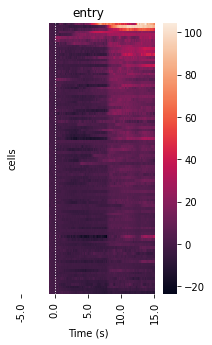

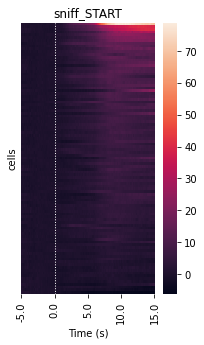

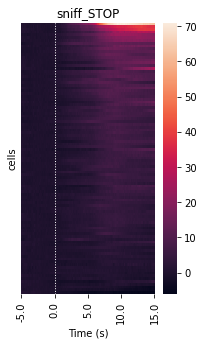

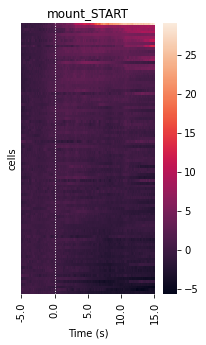

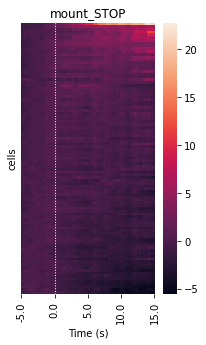

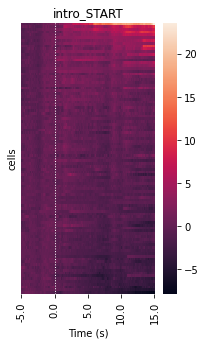

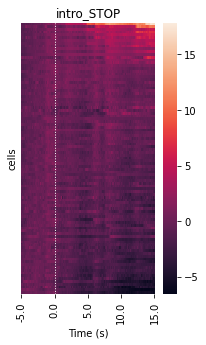

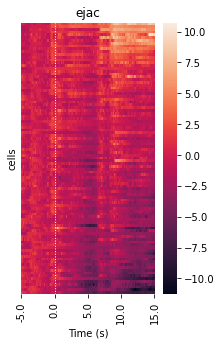

In [22]:
for idx,behavior_key in enumerate(frame_dict.keys()):
    #print('processing ' + behavior_key)

    __,raw_array = extract_array(subset_tracedf,frame_dict,behavior_key,before_frames,after_frames)
    if len(raw_array) == 0:
        continue
    
    # z score the raw_array
    zscores = (raw_array - np.nanmean(raw_array[:,:before_frames,:],axis = 1)[:,None,:])/np.nanstd(raw_array[:,:before_frames,:],axis = 1)[:,None,:]    
    zscores = np.nanmean(zscores,axis = 0).T


    if plot_key:
        sortindex = np.argsort(np.nanmean(zscores[:,before_frames:before_frames+after_frames],axis = 1))[::-1]


        fig,axs = plt.subplots(1,1,figsize = (3,5))
        sns.heatmap(zscores[sortindex,:],ax = axs)
        axs.set_xticks(np.linspace(0,(before_frames+after_frames),4 +1))
        axs.set_xticklabels(np.linspace(-before_window,after_window,int((before_frames+after_frames)/(signal_framerate*5)) +1 ))
        axs.axvline(before_frames,color = 'white',linestyle = ':',linewidth = 1)
        axs.set_yticks([])
        axs.set_ylabel('cells')
        axs.set_xlabel('Time (s)')
        axs.set_title(behavior_key)
        fig.savefig(os.path.join(individualfigurepath,data_key + '_' + behavior_key+'.png'))    